## Predicting Apartment Prices in Mexico City 

Goal: A consolidation of the contents in 0-price-and size, 1-price-and-location, 2-price-and-neighborhood, and price-and-everything using the mexico dataset.

In [9]:
# Import libraries here
from glob import glob

import pandas as pd
import numpy as np

import seaborn as sns
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
import matplotlib.pyplot as plt
import plotly.express as px

from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

### Prepare Data

#### Import

In [3]:
# Build your `wrangle` function
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    # Subset data: Apartments in "Distrito Federal", less than 100, 0000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]
    
    # subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    # split lat and lon columns
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Create a feature "borough"
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop columns with more than 50% null values
    df.drop(columns =["surface_total_in_m2",
                      "price_usd_per_m2",
                      "rooms",
                      "floor",
                      "expenses"], inplace=True)
    # Drropp columns with low and high cardinality categiorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # drop leaky columns
    df.drop(columns=["price", "price_aprox_local_currency", "price_per_m2"], inplace=True)
    
    # drop columns with multicollinearity
    None
    return df

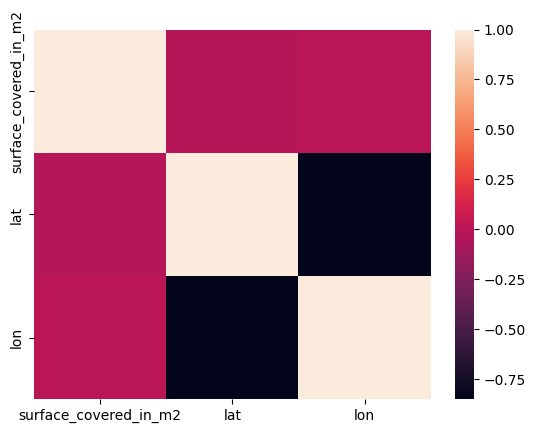

In [4]:
# Testing wrangle function and explore the data
files = glob("data/mexico-city-real-estate*.csv")
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
corr = round(df.select_dtypes("number").drop(columns="price_aprox_usd").corr(), 4)
sns.heatmap(corr);

Collect files using glob function

In [5]:
file = glob("data/mexico-city-real-*.csv")
files

['data\\mexico-city-real-estate-1.csv',
 'data\\mexico-city-real-estate-2.csv',
 'data\\mexico-city-real-estate-3.csv',
 'data\\mexico-city-real-estate-4.csv',
 'data\\mexico-city-real-estate-5.csv']

Create a DataFrame

In [6]:
df = pd.concat([wrangle(file) for file in files])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5473 entries, 11 to 4618
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


#### Explore

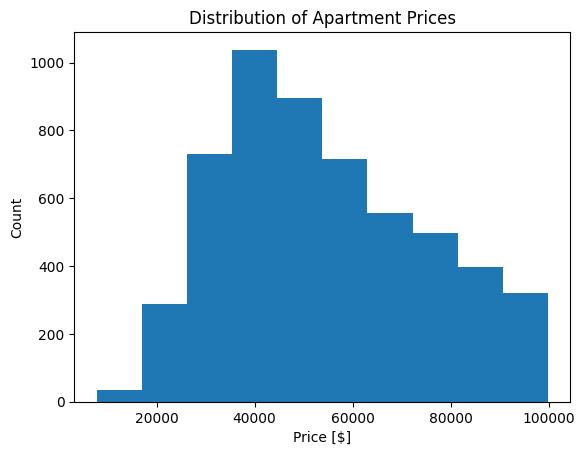

In [11]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")

# Add title
plt.title("Distribution of Apartment Prices");
plt.savefig("images/2-5-4.png", dpi=150)


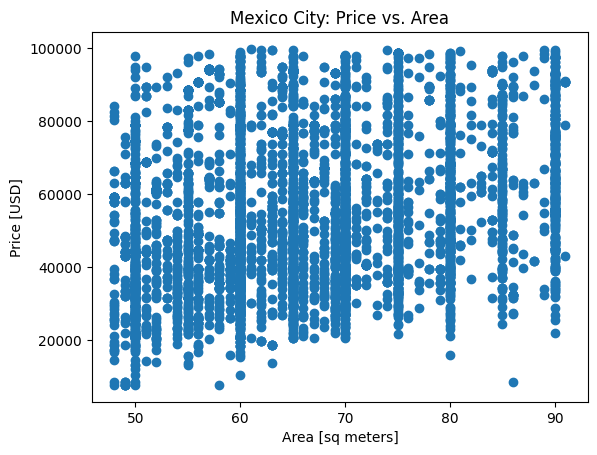

In [12]:
# Build scatter plot
plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"]);


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Mexico City: Price vs. Area");


plt.savefig("images/2-5-5.png", dpi=150)

In [13]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,
    lat = "lat",
    lon = "lon",
    width = 600,
    height = 600,
    color = "price_aprox_usd",
    hover_data = ["price_aprox_usd"],
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

#### Split

In [14]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"
features = ['surface_covered_in_m2', 'lat', 'lon', 'borough']
X_train = df[features]
y_train = df[target]

#### Build Model

##### Baseline

In [15]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


##### Iterrate

In [16]:
# Build Model
model = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge()
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['borough'])),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

#### Evaluate

In [17]:
X_test = pd.read_csv("data/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


In [18]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

### Comunicate Results

In [19]:
coefficients = model.named_steps['ridge'].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index=features)
feat_imp

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\category_encoders\utils.py:366: FutureWarning:

`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.



surface_covered_in_m2      291.654156
lat                        478.901375
lon                      -2492.221814
borough_1                13778.188880
borough_2                  405.403127
borough_3                 2459.288646
borough_4                 3737.561001
borough_5                 3275.121061
borough_6               -13349.017448
borough_7                 -350.531990
borough_8               -14166.869486
borough_9                 1977.314718
borough_10               -5609.918629
borough_11               10319.429804
borough_12               -6637.429757
borough_13                 929.857400
borough_14               -5925.666450
borough_15                9157.269123
dtype: float64

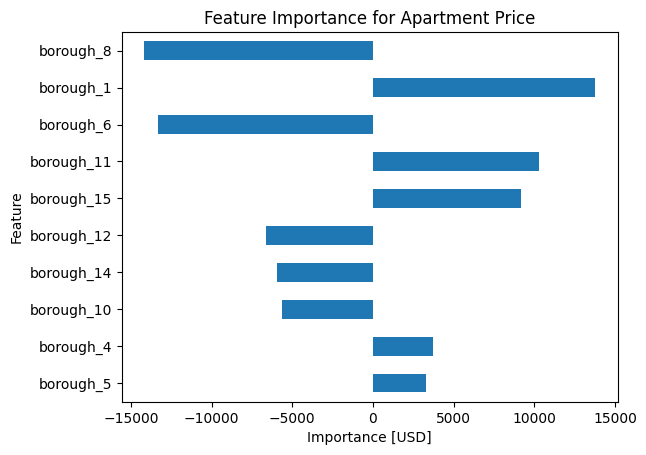

In [20]:
# Top 15 features
feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price");

plt.savefig("images/2-5-13.png", dpi=150)
